# Imports

In [1]:
import cv2

import time 
import requests
import operator

# This opens an inteactive figure - use it in part B
import matplotlib
matplotlib.use('TkAgg')
import pandas as pd
import json
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import null_space
from numpy.linalg import pinv
#import pytesseract
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
from collections import Counter
from sklearn.cluster import KMeans

# Import library to display results
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline 
# Display images within Jupyter
# This specifies the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'
%matplotlib qt

In [2]:
try:
    from PIL import Image
except ImportError:
    import Image

# Helper methods

In [3]:
def show_image(im):
    %matplotlib inline
    #plt.rcParams['figure.figsize'] = (14, 14) 
    f, ax1 = plt.subplots(1, 1)
    ax1.imshow(im)
    f.tight_layout()
    plt.show()

In [4]:
def select_box_corners(img, shouldUseHardCoded, hardcoded_points):
    # This sould open a new figure window outside of jupyter notebook

    plt.rcParams['figure.figsize'] = (14.0, 14.0) 
    f, ax = plt.subplots(1, 1)

    ax.imshow(img)
    ax.set_title('Pop image')

    if(shouldUseHardCoded):
        data = hardcoded_points
    else:
        data = plt.ginput(4)
       
    top_L = data[0]
    top_R = data[1]
    bottom_L = data[3]
    bottom_R = data[2]
    
    plt.plot()

    %matplotlib inline 
     
    plt.rcParams['figure.figsize'] = (14.0, 14.0) 
    f, ax2 = plt.subplots(1, 1)
    ax2.imshow(img)
    
    ax2.plot([top_L[0] ,top_R[0]], [top_L[1] ,top_R[1]], color = 'y',linewidth=4)
    ax2.plot([bottom_L[0] ,bottom_R[0]], [bottom_L[1] ,bottom_R[1]], color = 'y',linewidth=4)
    ax2.plot([top_R[0] ,bottom_R[0]], [top_R[1] ,bottom_R[1]], color = 'y',linewidth=4)
    ax2.plot([bottom_L[0] ,top_L[0]], [bottom_L[1] ,top_L[1]], color = 'y',linewidth=4)

    pts = np.zeros((4, 2), dtype = "float32")
    pts[0] = top_L
    pts[1] = top_R
    pts[2] = bottom_R
    pts[3] = bottom_L
    return pts

## OCR

In [5]:
# OCR Variables
_url = 'https://popvision.cognitiveservices.azure.com/vision/v2.0/recognizeText' # Here, paste your full endpoint from the Azure portal
_key = '4d08194ed34d4a3eb5d50a2e4de77cc5'  # Here, paste your primary key
_maxNumRetries = 10

In [6]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:
        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429:
            print( "Message: %s" % ( response.json() ) )
            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break
        elif response.status_code == 202:
            result = response.headers['Operation-Location']
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )
        break
        
    return result

In [7]:
def getOCRTextResult( operationLocation, headers ):
    """
    Helper function to get text result from operation location

    Parameters:
    operationLocation: operationLocation to get text result, See API Documentation
    headers: Used to pass the key information
    """

    retries = 0
    result = None

    while True:
        response = requests.request('get', operationLocation, json=None, data=None, headers=headers, params=None)
        if response.status_code == 429:
            print("Message: %s" % (response.json()))
            if retries <= _maxNumRetries:
                time.sleep(1)
                retries += 1
                continue
            else:
                print('Error: failed after retrying!')
                break
        elif response.status_code == 200:
            result = response.json()
        else:
            print("Error code: %d" % (response.status_code))
            print("Message: %s" % (response.json()))
        break

    return result

In [8]:
def showResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    img = img[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(img, aspect='equal')

    lines = result['recognitionResult']['lines']

    for i in range(len(lines)):
        words = lines[i]['words']
        for j in range(len(words)):
            tl = (words[j]['boundingBox'][0], words[j]['boundingBox'][1])
            tr = (words[j]['boundingBox'][2], words[j]['boundingBox'][3])
            br = (words[j]['boundingBox'][4], words[j]['boundingBox'][5])
            bl = (words[j]['boundingBox'][6], words[j]['boundingBox'][7])
            text = words[j]['text']
            x = [tl[0], tr[0], tr[0], br[0], br[0], bl[0], bl[0], tl[0]]
            y = [tl[1], tr[1], tr[1], br[1], br[1], bl[1], bl[1], tl[1]]
            line = Line2D(x, y, linewidth=3.5, color='red')
            ax.add_line(line)
            ax.text(tl[0], tl[1] - 2, '{:s}'.format(text),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.show()

In [9]:
def OCR_image(img):
    im = Image.fromarray(img)
    im.save("number.jpg")
    pathToFileInDisk = r'.\number.jpg'
    with open(pathToFileInDisk, 'rb') as f:
        data = f.read()

    # Computer Vision parameters
    params = {'mode' : 'Handwritten'}

    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/octet-stream'

    json = None

    operationLocation = processRequest(json, data, headers, params)

    result = None
    if (operationLocation != None):
        headers = {}
        headers['Ocp-Apim-Subscription-Key'] = _key
        while True:
            time.sleep(1)
            result = getOCRTextResult(operationLocation, headers)
            if result['status'] == 'Succeeded' or result['status'] == 'Failed':
                break

    # Load the original image, fetched from the URL
    if result is not None and result['status'] == 'Succeeded':
        data8uint = np.fromstring(data, np.uint8)  # Convert string to an unsigned int array
        img = cv2.cvtColor(cv2.imdecode(data8uint, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        showResultOnImage(result, img)
        return result

# Data set

In [10]:
import json
import pandas as pd
with open('./pops_dataset.json', 'r') as f:
    data = json.load(f)

In [11]:
print(f'Total unique POPs: {data["total"]}')

Total unique POPs: 9715


In [12]:
data["hits"][0]

{'uid': 'db0c5f67-ab2a-48d6-a076-3345d754b6cb',
 'type': 'catalog',
 'title': 'Devil Flanders (Glows in the Dark)',
 'referenceUrl': 'devil-flanders-glows-in-the-dark',
 'visibleDate': '2020-08-25T00:00:00-07:00',
 'releaseDate': '2020-08-25T00:00:00-07:00',
 'keywords': ['Vinyl Figure',
  'Pop',
  'Pop Vinyl',
  '51399',
  '2020',
  '2020 Pop',
  '2020 Pop Vinyl',
  'Amazon',
  'Amazon Pop',
  'Glows in the Dark',
  'Ned Flanders Pop',
  'Ned Flanders Pop Vinyl',
  'The Simpsons Vinyl Figure',
  'Animation Pop',
  'Pop Animation',
  'Ned Flanders',
  'The Simpsons',
  '20th Century Fox Licensing',
  'Animation'],
 'score': 43.690678,
 'imageUrl': '/craftmin/products/51399_Simpsons_Flanders_devil_POP_GLAM-1-WEB-AMZ-08b50002b8f0538718f0215c79f6a7dd.png',
 'additionalImages': ['/craftmin/products/51399_Simpsons_Flanders_devil_POP_GLAM-1-WEB-AMZ-08b50002b8f0538718f0215c79f6a7dd.png',
  '/craftmin/products/50141b_Simpsons_Flanders_devil_POP_GLAM-WEB-f835633f359fc059ae2692737db433f5.png'],


In [13]:
pops_dataframe = pd.DataFrame(data["hits"])
pops_dataframe

uid     type  \
0     db0c5f67-ab2a-48d6-a076-3345d754b6cb  catalog   
1     963dc51d-e6f7-487f-a380-7dc480334367  catalog   
2     8db8c4e0-069a-4b73-bb10-527e3e7787c6  catalog   
3     7eb56d3c-5203-4882-8e7d-9f9a763acfc9  catalog   
4     73d3092b-eeb8-4609-a50f-1cfb27e960af  catalog   
...                                    ...      ...   
9710  57fa4c43-9238-4fea-924f-bec8db1321f3  catalog   
9711  54a9e42c-c6f6-45cc-ac11-0009b7805dad  catalog   
9712  1bcd491d-68c4-48ae-9c55-194f0319c284  catalog   
9713  78d6696d-f528-4d13-942b-0ceb6b28f8ec  catalog   
9714  8a2bf93c-aaeb-4a1e-a035-d0fd6f2bc18d  catalog   

                                    title  \
0      Devil Flanders (Glows in the Dark)   
1                  Macho Man Randy Savage   
2     Macho Rand Savage (Diamond Glitter)   
3                                The Rock   
4                                   Mr. T   
...                                   ...   
9710          Superman (Metallic) (Chase)   
9711               Batgirl (Black) (SDCC)   
9712         Green Lantern (Glow) (Green)   
9713                  Master Chief (Blue)   
9714                                Smurf   

                             referenceUrl                visibleDate  \
0        devil-flanders-glows-in-the-dark  2020-08-25T00:00:00-07:00   
1                macho-man-randy-savage-3  2020-08-25T00:00:00-07:00   
2       macho-rand-savage-diamond-glitter  2020-08-25T00:00:00-07:00   
3                              the-rock-1  2020-08-25T00:00:00-07:00   
4                                  mr-t-5  2020-08-25T00:00:00-07:00   
...                                   ...                        ...   
9710  superman-metallic-chase-bobble-head  2010-01-01T00:00:00-08:00   
9711                   batgirl-black-sdcc  2010-01-01T00:00:00-08:00   
9712             green-lantern-glow-green  2010-01-01T00:00:00-08:00   
9713      comic-con-halo-3-blue-exclusive  2008-06-01T00:00:00-07:00   
9714                                smurf  2000-01-01T00:00:00-08:00   

                    releaseDate  \
0     2020-08-25T00:00:00-07:00   
1     2020-08-25T00:00:00-07:00   
2     2020-08-25T00:00:00-07:00   
3     2020-08-25T00:00:00-07:00   
4     2020-08-25T00:00:00-07:00   
...                         ...   
9710  2010-01-01T00:00:00-08:00   
9711  2010-01-01T00:00:00-08:00   
9712  2010-01-01T00:00:00-08:00   
9713  2008-06-01T00:00:00-07:00   
9714  2000-01-01T00:00:00-08:00   

                                               keywords      score  \
0     [Vinyl Figure, Pop, Pop Vinyl, 51399, 2020, 20...  43.690678   
1     [Vinyl Figure, Pop, Pop Vinyl, 49264, 2020, 20...  43.690678   
2     [Vinyl Figure, Pop, Pop Vinyl, 51778, 2020, 20...  43.690678   
3     [Vinyl Figure, Pop, Pop Vinyl, 49262, 2020, 20...  43.690678   
4     [Vinyl Figure, Pop, Pop Vinyl, 49266, 2020, 20...  43.690678   
...                                                 ...        ...   
9710  [Vinyl Figure, Pop, Pop Vinyl, 2250, 2010, 201...  42.552820   
9711  [Vinyl Figure, Pop, Pop Vinyl, Funko2019000112...  42.552820   
9712  [Vinyl Figure, Pop, Pop Vinyl, Funko2019000111...  42.552820   
9713  [Vinyl Figure, Pop, Pop Vinyl, 8420, 2008, 200...  42.552820   
9714  [Vinyl Figure, Pop, Pop Vinyl, Funko2019000305...  42.552820   

                                               imageUrl  \
0     /craftmin/products/51399_Simpsons_Flanders_dev...   
1     /craftmin/products/49264a-9c167badea7d1ca559fe...   
2     /craftmin/products/51778a-12805510c78d7f18bdd5...   
3     /craftmin/products/49262-1f1b01fcba49ed04b6b74...   
4     /craftmin/products/49266-8498fb00b9f611984d988...   
...                                                 ...   
9710  /craftmin/products/5c660b72022d7_superman-meta...   
9711   /craftmin/products/5c66066742d87_00000011882.jpg   
9712   /craftmin/products/5c6606611d88c_00000011868.jpg   
9713  /craftmin/products/1436_3266_Funko_Pop_Halo_01...   
9714   /craftmin/products/5c660af601bb6_00000018467.jpg   

 

In [14]:
pops_dataframe = pops_dataframe[pops_dataframe["boxNumber"].notnull()]
pops_dataframe

uid     type  \
0     db0c5f67-ab2a-48d6-a076-3345d754b6cb  catalog   
9     fc939ba4-eb7f-43b3-95a7-52653b481e69  catalog   
10    4919ea0c-7773-40c6-a65d-3d0acbba9ccf  catalog   
11    cfca62f4-8352-4394-b452-dd0f78c7d701  catalog   
12    6b26a746-31d4-4178-bb68-ee97cbb5c61f  catalog   
...                                    ...      ...   
9672  3b35713e-82e7-4a9e-8641-035fdfa96ad1  catalog   
9673  6877ebd0-083c-4ad9-9da5-140a9c1a2947  catalog   
9700  ad3025ed-cf48-46f3-a5e7-302a366927c7  catalog   
9701  9e396eac-52da-456a-a73d-de3de14d07c7  catalog   
9702  2c7707f7-46f2-4ede-b594-303cef3aabdc  catalog   

                                   title                      referenceUrl  \
0     Devil Flanders (Glows in the Dark)  devil-flanders-glows-in-the-dark   
9                            Casey Jones                     casey-jones-2   
10                              Leonardo                        leonardo-8   
11              Concept Series Chewbacca          concept-series-chewbacca   
12             Concept Series Starkiller         concept-series-starkiller   
...                                  ...                               ...   
9672                             Dorothy                pop-movies-dorothy   
9673                      Jason Voorhees       pop-movies-jason-voorhees-1   
9700                   The Flash (Chase)                      the-flash-17   
9701                           The Joker              pop-heroes-the-joker   
9702          Green Lantern (Hal Jordan)          pop-heroes-green-lantern   

                    visibleDate                releaseDate  \
0     2020-08-25T00:00:00-07:00  2020-08-25T00:00:00-07:00   
9     2020-08-24T00:00:00-07:00  2020-08-24T00:00:00-07:00   
10    2020-08-24T00:00:00-07:00  2020-08-24T00:00:00-07:00   
11    2020-08-21T00:00:00-07:00  2020-08-21T00:00:00-07:00   
12    2020-08-21T00:00:00-07:00  2020-08-21T00:00:00-07:00   
...                         ...                        ...   
9672  2011-05-01T00:00:00-07:00  2011-05-01T00:00:00-07:00   
9673  2011-03-02T00:00:00-08:00  2011-03-02T00:00:00-08:00   
9700  2010-11-17T00:00:00-08:00  2010-11-17T00:00:00-08:00   
9701  2010-11-17T00:00:00-08:00  2010-11-17T00:00:00-08:00   
9702  2010-07-31T00:00:00-07:00  2010-07-31T00:00:00-07:00   

                                               keywords      score  \
0     [Vinyl Figure, Pop, Pop Vinyl, 51399, 2020, 20...  43.690678   
9     [Vinyl Figure, Pop, Pop Vinyl, 51436, 2020, 20...  43.690678   
10    [Vinyl Figure, Pop, Pop Vinyl, 51435, 2020, 20...  43.690678   
11    [Vinyl Figure, Pop, Pop Vinyl, 49372, 2020, 20...  43.690678   
12    [Vinyl Figure, Pop, Pop Vinyl, 49374, 2020, 20...  43.690678   
...                                                 ...        ...   
9672  [Vinyl Figure, Pop, Pop Vinyl, 2356, 2011, 201...  42.552820   
9673  [Vinyl Figure, Pop, Pop Vinyl, 2292, 2011, 201...  42.552820   
9700  [Vinyl Figure, Pop, Pop Vinyl, 2248, 2010, 201...  42.552820   
9701  [Vinyl Figure, Pop, Pop Vinyl, 2211, 2010, 201...  42.552820   
9702  [Vinyl Figure, Pop, Pop Vinyl, 2178, 2010, 201...  42.552820   

                                               imageUrl  \
0     /craftmin/products/51399_Simpsons_Flanders_dev...   
9     /craftmin/products/51436_POP_TMNT_CaseyJones_G...   
10    /craftmin/products/51435_POP_TMNT_LEONARDO_GLA...   
11    /craftmin/products/49372_SW_Concept_Chewbacca_...   
12    /craftmin/products/49374_SW_Concept_Starkiller...   
...                                                 ...   
9672  /craftmin/products/1436_3266_Dorothy_OZ_POP_Gl...   
9673    /craftmin/products/1436_3266_JASON_POP_GLAM.jpg   
9700  /craftmin/products/the-flash-metallic-chase-10...   
9701  /craftmin/products/1436_3266_2211_POP_Heroes_T...   
9702  /craftmin/products/1436_3266_09_GreenLanternPo...   

                                       additionalImages  ...  \
0     [/craftmin/products/51399_Simpsons_Flanders_de...  ...   
9     [/craftmin/p

In [15]:
box_numbers = pops_dataframe["boxNumber"].astype(int)
plt.figure(figsize=(20,10))
plt.xticks(np.arange(0, max(box_numbers)+1, 50))

plt.hist(box_numbers, bins = 1060)
plt.title(f'Histogram of box numbers')
plt.xlabel('Box number')
plt.ylabel('Sample amount')

plt.show()

In [16]:
#box_numbers_keys = list(Counter(box_numbers.sort_values()).keys())
#box_numbers_freq = list(Counter(box_numbers.sort_values()).values())
#list(zip(box_numbers_keys,box_numbers_freq))

In [17]:
box_numbers_freq = list(Counter(box_numbers.sort_values()).values())
seaborn.boxplot(box_numbers_freq)

D:\Tools\anaconda3\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Histogram of box numbers'}, xlabel='Box number', ylabel='Sample amount'>

# Identify pop boxes in image

In [18]:
#image = cv2.cvtColor(cv2.imread('pop1.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)

In [19]:
image = cv2.cvtColor(cv2.imread('rouge_pop.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)

array([[ 78.146645, 182.45805 ],
       [677.3267  , 171.10518 ],
       [658.4052  , 848.494   ],
       [171.49258 , 853.53973 ]], dtype=float32)

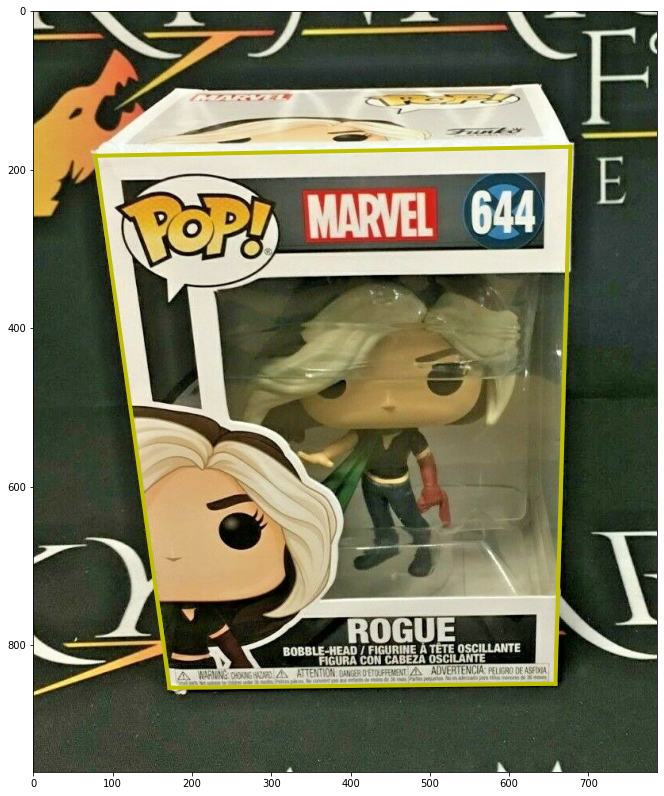

In [20]:
hardcoded_points = np.array([[175.22964  ,   1.3064516],
       [504.56912  ,   6.2219663],
       [504.56912  , 448.6183   ],
       [186.28955  , 454.76266  ]])

hardcoded_points2 = np.array([[ 76.88521, 176.1509 ],
       [678.58813, 166.05945],
       [660.9281 , 844.7097 ],
       [174.01546, 853.53973]])

#points = select_box_corners(image, True, hardcoded_points)
#points = select_box_corners(image, True, hardcoded_points2)
points = select_box_corners(image, False, hardcoded_points)
points

# Homography / Rectification of pop box

In [21]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
    return rect


#Homography function 
def four_point_transform(image, pts):
    #Preserves lines 
    
    # Input a consistent order of the points and unpack them individually
    rect = pts
    (tl, tr, br, bl) = rect
    #Based on the template image we have a defined set of values for height and width
    #Each image will be scaled to these values and transformed in a perspective transformation- a type of homography
    #All straight lines will be preserved
    setH = 1590
    setW = 1121
    #Size of desired output image
    dst = np.array([[0, 0], [setW - 1, 0], [setW - 1, setH - 1], [0, setH - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(pts, dst)
    warped = cv2.warpPerspective(image, M, (setW, setH))
  
    return warped

In [22]:
warped = four_point_transform(image, points)

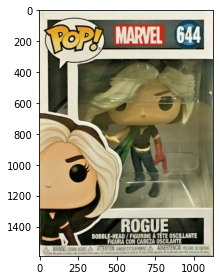

(None, (1590, 1121, 3))

In [23]:
show_image(warped), warped.shape

# Extract and identify pop series number

In [24]:
def extract_segments(img):
    pop = img[0:380,:420]
    number = img[50:270,850:1100]
    fran_name = img[50:270, 420:850]
    char_name = img[1300:1530,315:]
    figure = img[570:,0:580]
    return (pop, number, fran_name, char_name, figure)

In [25]:
(segment_pop, segment_number, segment_fran_name, segment_char_name, segment_figure) = extract_segments(warped)

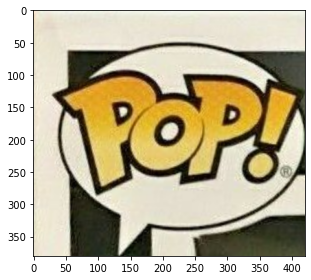

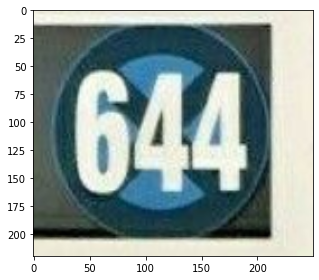

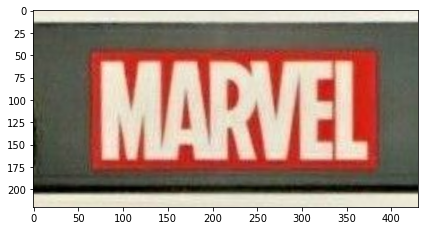

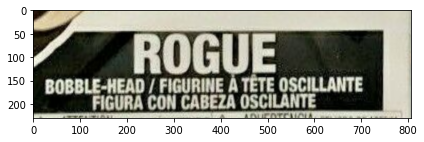

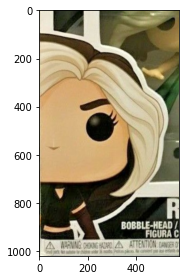

In [26]:
show_image(segment_pop)
show_image(segment_number)
show_image(segment_fran_name)
show_image(segment_char_name)
show_image(segment_figure)

# Preparing number for OCR

In [27]:
gray_number_image = cv2.cvtColor(segment_number, cv2.COLOR_BGR2GRAY)

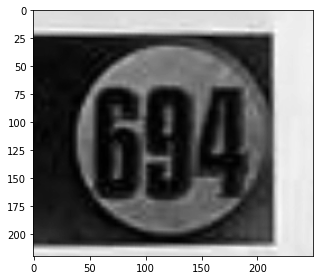

In [28]:
show_image(gray_number_image)

In [29]:
def find_circle_in_img(img):
    img_circled = img.copy()
    blurred = cv2.medianBlur(img_circled, 25)

    minDist = 100
    param1 = 30
    param2 = 40
    minRadius = 10
    maxRadius = 100

    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:]:
            cv2.circle(img_circled, (i[0], i[1]), i[2], (0, 255, 0), 2)
    return img_circled, circles[0][0]

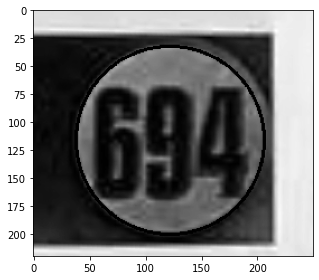

array([122, 116,  84], dtype=uint16)

In [30]:
gray_number_image_circled, circle = find_circle_in_img(gray_number_image)
show_image(gray_number_image_circled)
circle

In [31]:
def crop_image_circle(img, circle):
    x, y, r = circle
    print(x, y, r)
    mask = np.zeros((img.shape[0], img.shape[1]),dtype=np.uint8)
    cv2.circle(mask,(x,y),r,(255,255,255),-1)
    #out = img*mask
    #white = 255-mask
    #cropped = out+white
    #return cropped
    masked = cv2.bitwise_and(img, img, mask=mask)
    return masked

122 116 84


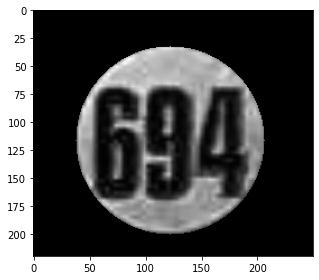

In [32]:
cropped = crop_image_circle(gray_number_image, circle)
show_image(cropped)

In [33]:
def get_center_patch(img, x, y, window_size):
    return img[x-windows_size:x+windows_size, y-windows_size:y+windows_size]

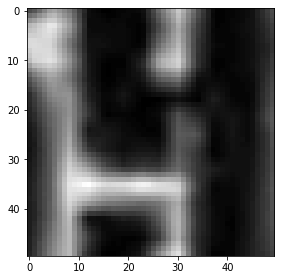

In [34]:
x, y, _ = circle
windows_size = 25

circle_center = get_center_patch(cropped, x, y, windows_size)
show_image(circle_center)

In [35]:
def get_dominant_color_in_patch(patch):
    histogram, bin_edges = np.histogram(patch, bins=100, range=(0, 255))
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.plot(bin_edges[0:-1], histogram)
    plt.show()
    histogram_values = list(zip(bin_edges[0:-1], histogram))
    most_dominate_color = max(histogram_values, key=lambda x:x[1])
    print(f'most dominant color scale approx: {most_dominate_color[0]} \
    with {most_dominate_color[1]} occurances ({circle_center.shape[0]*circle_center.shape[1]})')
    return most_dominate_color[0]

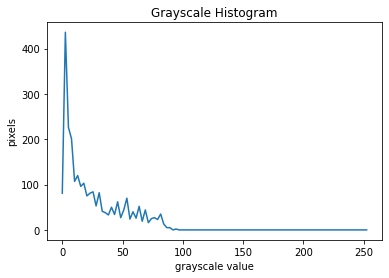

most dominant color scale approx: 2.55     with 436 occurances (2500)


In [36]:
dominant_color = get_dominant_color_in_patch(circle_center)

In [37]:
dominant_color

2.55

In [38]:
def threshold_image_by_range(img, color_level, threshold):
    th_low = color_level - threshold
    th_high = color_level + threshold

    cleaned = img.copy()
    cleaned[cleaned < th_low] = 255
    cleaned[cleaned > th_high] = 255
    return cleaned

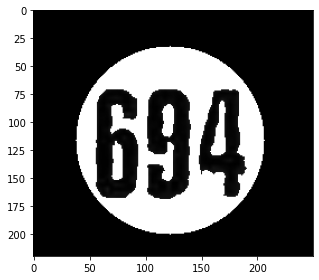

In [39]:
threshold = 20
cleaned = threshold_image_by_range(cropped, dominant_color, threshold)
show_image(cleaned)

<ipython-input-9-9a847932b58a>:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data8uint = np.fromstring(data, np.uint8)  # Convert string to an unsigned int array


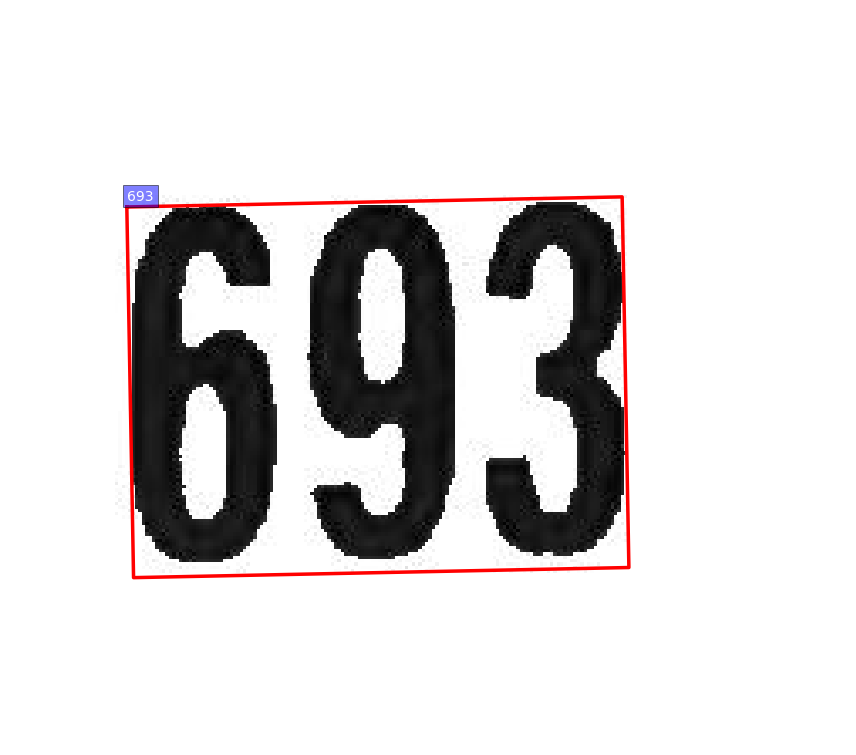

In [40]:
ocr_result = OCR_image(cleaned)

In [40]:
def clean_number_for_ocr(number_segment):
    show_image(number_segment)
    gray_number_image = cv2.cvtColor(number_segment, cv2.COLOR_BGR2GRAY)
    show_image(gray_number_image)
    gray_number_image_circled, circle = find_circle_in_img(gray_number_image)
    show_image(gray_number_image_circled)
    circle
    cropped = crop_image_circle(gray_number_image, circle)
    show_image(cropped)
    x, y, _ = circle
    windows_size = 25

    circle_center = get_center_patch(cropped, x, y, windows_size)
    show_image(circle_center)
    dominant_color = get_dominant_color_in_patch(circle_center)
    threshold = 20
    cleaned = threshold_image_by_range(cropped, dominant_color, threshold)
    show_image(cleaned)

In [37]:
detected_box_number = int(ocr_result['recognitionResult']['lines'][0]['text'])
detected_box_number

644

In [65]:
#img_new = Image.fromarray(number)
#text = pytesseract.image_to_string(gray_number, lang='eng',  config='digits')
#print(text)

## Figure segmentation

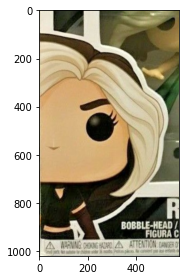

In [27]:
show_image(segment_figure)

In [28]:
def get_dominant_bright_color_in_patch(patch):
    histogram, bin_edges = np.histogram(patch, bins=100, range=(0, 255))
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.plot(bin_edges[0:-1], histogram)
    plt.show()
    histogram_values = list(zip(bin_edges[0:-1], histogram))
    
    for i in range(99,0,-1):
        if (histogram_values[i][1] > 30000):
            return histogram_values[i][0]
    
    print("NONE FOUND")

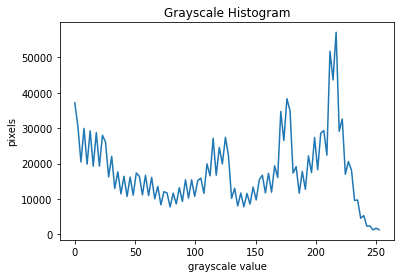

221.85

In [29]:
dominant_bright_color = get_dominant_bright_color_in_patch(segment_figure)
dominant_bright_color

In [30]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

In [37]:
def extract_figure(img):
    dial_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    show_image(img)

    figure_threshold_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show_image(figure_threshold_gray)
    figure_threshold_gray
    th_res = cv2.inRange(figure_threshold_gray, dominant_bright_color-1, dominant_bright_color+1)
    th_res = cv2.bitwise_not(th_res)
    th_res_canny = cv2.Canny(th_res,100,150)
    th_res_canny = cv2.bitwise_not(th_res_canny)

    show_image(th_res)
    show_image(th_res_canny)
    segmented_figure_dialted = cv2.erode(th_res_canny,dial_kernel,iterations = 6)
    show_image(segmented_figure_dialted)

    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(segmented_figure_dialted)
    histogram, bin_edges = np.histogram(labels_im, bins=255)
    unique, counts = np.unique(labels_im, return_counts=True)
    label_freq = list(zip(unique, counts))
    print(label_freq)

    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.plot(bin_edges[0:-1], histogram)
    plt.show()

    show_image(imshow_components(labels_im))

    num_of_figure_cc = max(label_freq, key=lambda x:x[1])[0]

    labeled_img = imshow_components(labels_im)

    labels_im[labels_im > num_of_figure_cc] = 0
    labels_im[labels_im < num_of_figure_cc] = 0
    labels_im[labels_im == num_of_figure_cc] = 1

    labeled_img = imshow_components(labels_im)

    show_image(labeled_img)
    show_image(labels_im)

    figure_component = figure_threshold_gray.copy()
    figure_component[labels_im == 0] = 0
    figure_component[labels_im > 0] = 255

    contours, hierarchy  = cv2.findContours(figure_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = cv2.drawContours(labels_im, contours, -1, (75,255,75), 2)
    cv2.fillPoly(img, contours, color=(255,255,255))

    show_image(img)

    mask = np.zeros((img.shape[0], img.shape[1]),dtype=np.uint8)
    mask[img > 0] = 1
    extracted_figure = cv2.bitwise_and(segment_figure,segment_figure,mask = mask)
    return extracted_figure

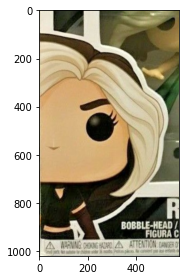

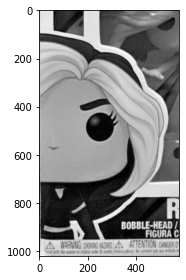

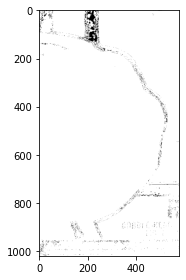

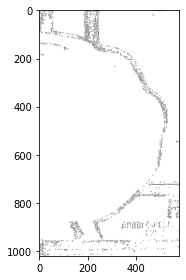

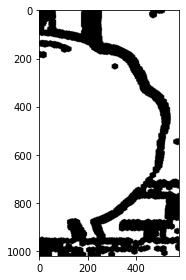

[(0, 141138), (1, 8991), (2, 94611), (3, 360), (4, 312753), (5, 216), (6, 1020), (7, 21080), (8, 2042), (9, 122), (10, 1321), (11, 6684), (12, 112), (13, 33), (14, 1), (15, 297), (16, 71), (17, 21), (18, 374), (19, 29), (20, 4), (21, 320)]


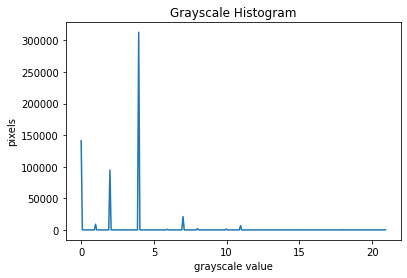

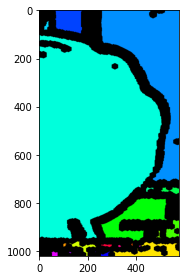

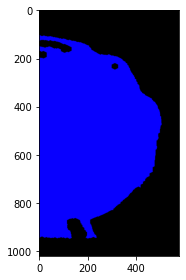

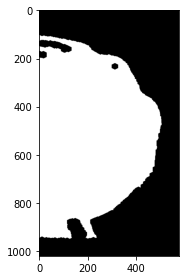

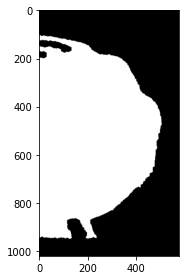

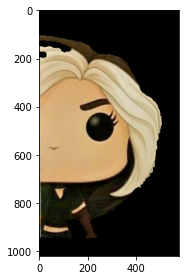

In [38]:
extracted_figure = extract_figure(segment_figure)
show_image(extracted_figure)

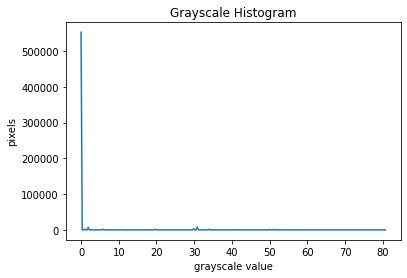

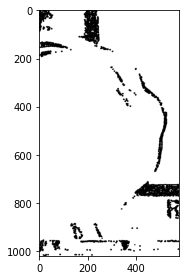

In [77]:
num_labels, labels_im = cv2.connectedComponents(edges_figure_dilated)
histogram, bin_edges = np.histogram(labels_im, bins=255)
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")

plt.plot(bin_edges[0:-1], histogram)
plt.show()

histogram_values = list(zip(bin_edges[0:-1], histogram))
most_dominated_component = max(histogram_values, key=lambda x:x[1])


most_dominated_component
max_filtered = labels_im.copy()
max_filtered[max_filtered != 0] = -1
max_filtered[max_filtered == 0] = 255
max_filtered[max_filtered == -1] = 0

show_image(max_filtered)

# Find candidates based on box number

In [44]:
matches_by_box_number = pops_dataframe[pops_dataframe["boxNumber"] == f'{detected_box_number}']
matches_by_box_number

uid     type           title  \
210   cf1ee78f-d9df-47fb-a9ad-86c9b4e74f3a  catalog           Rogue   
2253  37bddaa0-0086-417d-93f9-78ad7969579c  catalog  Pee-Wee Herman   

          referenceUrl                visibleDate                releaseDate  \
210            rogue-1  2020-05-14T10:00:00-07:00  2020-05-14T10:00:00-07:00   
2253  pee-wee-herman-1  2018-04-11T00:00:00-07:00  2018-04-11T00:00:00-07:00   

                                               keywords      score  \
210   [Vinyl Figure, Pop, Pop Vinyl, 49292, 2020, 20...  43.690678   
2253  [Vinyl Figure, Pop, Pop Vinyl, 21785, 2018, 20...  43.690678   

                                               imageUrl  \
210   /craftmin/products/1436_4202_8d7e7d96c19bb1c_4...   
2253  /craftmin/products/1436_3266_21785_Pee_wee_Pee...   

                                       additionalImages  ... siblings  isB2B  \
210   [/craftmin/products/1436_4202_8d7e7d96c19bb1c_...  ...       []   True   
2253  [/craftmin/products/1436_3266_21785_Pee_wee_Pe...  ...       []  False   

     hasChase caseQuantity masterCaseQty hobbyDbId  \
210     False          6.0          36.0    544219   
2253    False          6.0          36.0    377493   

                                    collectionData marketValue  \
210                                            NaN        11.0   
2253  {'inCollections': 5117, 'inWishlists': 1968}        21.0   

                                        historicPricing             tags  
210   {'week': {'numberOfSales': 0, 'averagePrice': ...              NaN  
2253  {'week': {'numberOfSales': 0, 'averagePrice': ...  [Classic/Retro]  

[2 rows x 47 columns]

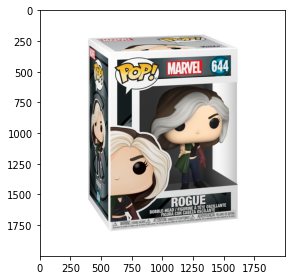

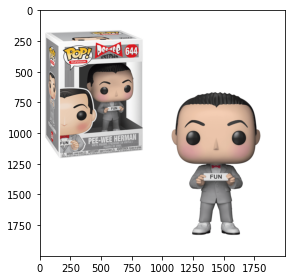

In [47]:
for i in range(matches_by_box_number.shape[0]):
    img_location = "D:/Code/funko\Data"+matches_by_box_number['imageUrl'].iloc[i]
    candidate_image = cv2.cvtColor(cv2.imread(img_location, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
    show_image(candidate_image)

<ipython-input-9-9a847932b58a>:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data8uint = np.fromstring(data, np.uint8)  # Convert string to an unsigned int array


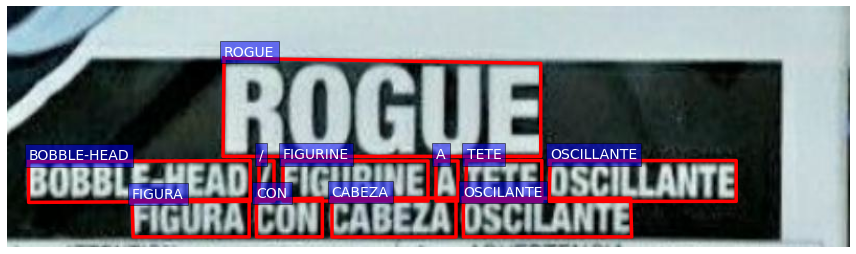

{'status': 'Succeeded',
 'recognitionResult': {'lines': [{'boundingBox': [200,
     48,
     514,
     51,
     513,
     146,
     199,
     143],
    'text': 'ROGUE',
    'words': [{'boundingBox': [207, 49, 510, 54, 510, 143, 206, 143],
      'text': 'ROGUE'}]},
   {'boundingBox': [17, 147, 698, 146, 698, 185, 17, 186],
    'text': 'BOBBLE-HEAD / FIGURINE A TETE OSCILLANTE',
    'words': [{'boundingBox': [20, 148, 232, 147, 232, 186, 20, 187],
      'text': 'BOBBLE-HEAD'},
     {'boundingBox': [240, 147, 255, 147, 255, 186, 240, 186], 'text': '/'},
     {'boundingBox': [263, 147, 402, 147, 402, 186, 263, 186],
      'text': 'FIGURINE'},
     {'boundingBox': [410, 147, 431, 147, 431, 186, 410, 186], 'text': 'A'},
     {'boundingBox': [439, 147, 511, 147, 511, 186, 438, 186], 'text': 'TETE'},
     {'boundingBox': [519, 147, 697, 147, 697, 186, 518, 186],
      'text': 'OSCILLANTE'}]},
   {'boundingBox': [116, 183, 597, 182, 597, 219, 116, 220],
    'text': 'FIGURA CON CABEZA OSCILANTE'

In [48]:
ocr_result_title = OCR_image(segment_char_name)
ocr_result_title

In [52]:
detected_ocr_title = ocr_result_title['recognitionResult']['lines'][0]['text']
detected_ocr_title

'ROGUE'

In [54]:
matches_by_box_number['title'].iloc[0]

'Rogue'

Matched with Rogue


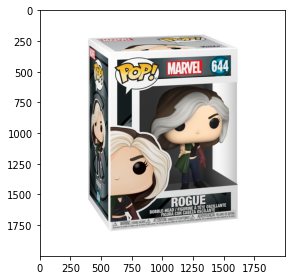

In [57]:
for i in range(matches_by_box_number.shape[0]):
    candidate_title = matches_by_box_number['title'].iloc[0]
    if (str(candidate_title).lower() == str(detected_ocr_title).lower()):
        print(f'Matched with {candidate_title}')
        img_location = "D:/Code/funko\Data"+matches_by_box_number['imageUrl'].iloc[i]
        candidate_image = cv2.cvtColor(cv2.imread(img_location, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
        show_image(candidate_image)
        break

# POP patch matching

In [90]:
def match_img(image, template, value):
    res = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    threshold = value
    min_v, max_v, min_pt, max_pt = cv2.minMaxLoc(res)
    if max_v < threshold:
        return False
    if not max_pt[0] in range(10, 40) or max_pt[1] > 20:
        return False
    return max_pt

(None, (441, 482, 3), (88, 96, 3))

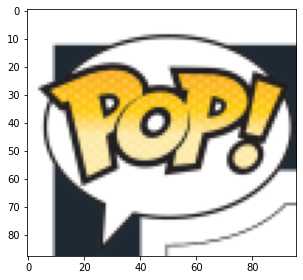

In [97]:
pop_patch = cv2.cvtColor(cv2.imread('pop_patch.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
scale_percent = 20
width = int(pop_patch.shape[1] * scale_percent / 100)
height = int(pop_patch.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

pop_patch_small = cv2.resize(pop_patch, dsize, interpolation = cv2.INTER_AREA)
show_image(pop_patch_small), pop_patch.shape, pop_patch_small.shape

(None, (320, 474, 3), (64, 94, 3))

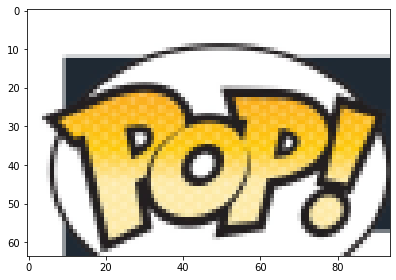

In [131]:
pop_patch = cv2.cvtColor(cv2.imread('pop_patch_2.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
scale_percent = 20
width = int(pop_patch.shape[1] * scale_percent / 100)
height = int(pop_patch.shape[0] * scale_percent / 100)

# dsize
dsize = (width, height)

pop_patch_small = cv2.resize(pop_patch, dsize, interpolation = cv2.INTER_AREA)
show_image(pop_patch_small), pop_patch.shape, pop_patch_small.shape

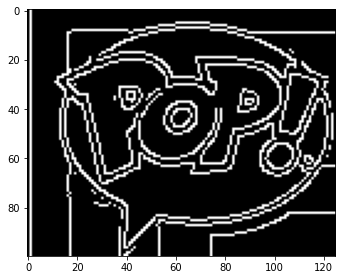

In [88]:
pop_candidate = warped[10:110,:125]
pop_candidate = cv2.Canny(pop_candidate,100,200)

show_image(pop_candidate)

In [113]:
match_img(warped, pop_patch_small, 0), cv2.matchTemplate(warped, pop_patch_small, cv2.TM_CCORR_NORMED).max()

(False, 0.8866915)

In [126]:
def is_pop_patch_matched(img, template, threshold):
    img2 = img.copy()
    w = template.shape[0]
    h = template.shape[1]

    meth = 'cv2.TM_CCORR_NORMED'
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCORR_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    print(f'{meth} max_val: {max_val}')
    plt.show()
    
    if( (max_val > threshold) and top_left[0] < 50 and top_left[1] < 50):
        return True
    return False

cv2.TM_CCORR_NORMED max_val: 0.8866915106773376


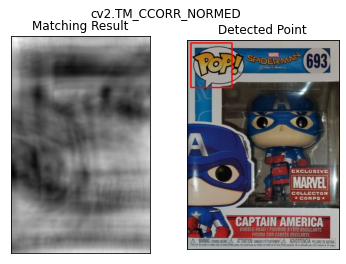

True

In [118]:
is_pop_patch_matched(warped, pop_patch_small, 0.8)

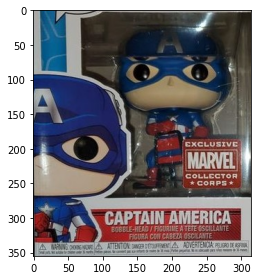

In [119]:
no_pop_image = cv2.cvtColor(cv2.imread('no_pop.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
show_image(no_pop_image)

cv2.TM_CCORR_NORMED max_val: 0.8397394418716431


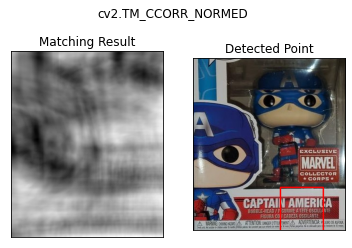

False

In [120]:
is_pop_patch_matched(no_pop_image, pop_patch_small, 0.8)

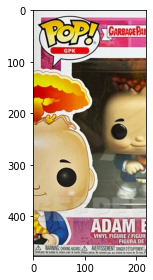

In [128]:
pop_extra_image = cv2.cvtColor(cv2.imread('pop_extra.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
show_image(pop_extra_image)

cv2.TM_CCORR_NORMED max_val: 0.2961920499801636


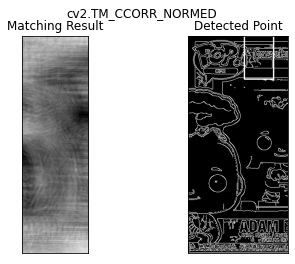

False

In [134]:
is_pop_patch_matched(cv2.Canny(pop_extra_image,100,200), cv2.Canny(pop_patch_small,100,200), 0.8)

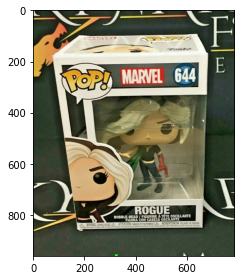

In [85]:
image = cv2.cvtColor(cv2.imread('rouge_pop.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gray, 130, 255, 1)

contours, hierarchy = cv2.findContours(canny, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)

font = cv2.FONT_HERSHEY_SIMPLEX    

for contour, hier in zip(contours, hierarchy):
    (x,y,w,h) = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, ('width = {}, height = {}'.format(w, h)),
                (x+30, y+30),
                font,
                1,
                (0, 255, 0),
                2,
                cv2.LINE_AA)

show_image(image)

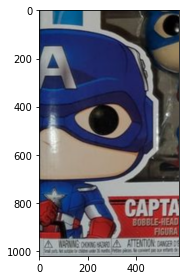

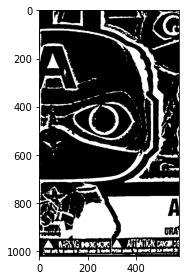

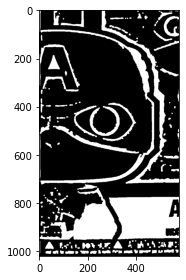

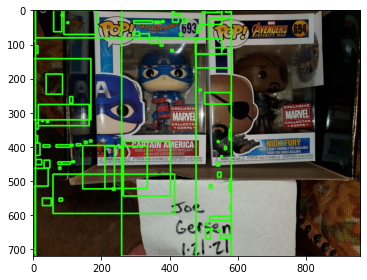

In [45]:
show_image(segment_figure)

# Load iamge, grayscale, adaptive threshold
#image = cv2.cvtColor(cv2.imread('pop1.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
#image = segmented_figure
#result = image.copy()
gray = cv2.cvtColor(segment_figure,cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

# Draw rectangles
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)

show_image(thresh)
show_image(opening)
show_image(image)

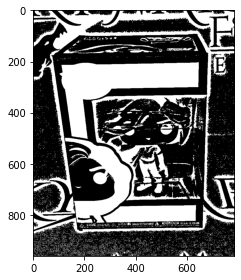

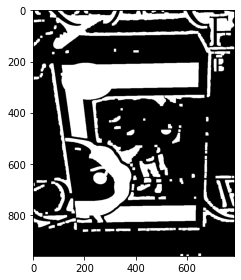

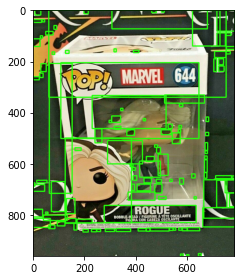

In [46]:
# Load iamge, grayscale, adaptive threshold
image = cv2.cvtColor(cv2.imread('rouge_pop.jpg', cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
result = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,9)

# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

# Draw rectangles
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)

show_image(thresh)
show_image(opening)
show_image(image)